В данном ноутбуке мы решим задачу оценки зарплаты пользователя по указанным данным.


**Импортируемые модули**

In [ ]:
# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

## Парсинг (обработка) базы

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)

'hh_fixed.csv'

In [ ]:
# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head()

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
# Пример данных

n = 0                                     # Индекс в таблице резюме
for i in range(len(df.values[n])):        # Вывод значения каждого столбца
    print('{:>2}  {}'.format(i, df.values[n][i]))

 0  Мужчина ,  29 лет , родился 16 мая 1989
 1  40000 руб.
 2  Специалист по поддержке чата(support team) домашний агент
 3  Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам
 4  полная занятость
 5  полный день
 6  Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая коммун

In [ ]:
# Настройка номеров столбцов
# Дальнейшие вычисления не будут зависеть от порядка столбцов в таблице

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

In [ ]:
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

In [ ]:
text = '    Мама\xa0 мыла\nРАМУ       \xa0 '
print(f'Неочищенная строка: {text}')
print()
print(f'Обработанная строка: {purify(text)}')

Неочищенная строка:     Мама  мыла
РАМУ         

Обработанная строка: мама мыла раму


In [ ]:
def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

In [ ]:
text = 'Пётр первый родился в ночь на 30.05.1672'
print(text)
print(extract_year(text))

Пётр первый родился в ночь на 30.05.1672
1672


In [ ]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0,
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0,
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0,
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]

In [ ]:
# Вычисление счетчиков для данных разбиения
for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [ ]:
def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
age = 32
int_to_ohe(age, age_class)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [ ]:
text = 'полная занятость'
print(text)
print(str_to_multi(text, employment_class))

полная занятость
[0. 0. 0. 1.]


In [ ]:
base_update_year = 2019

In [ ]:
# Разбор значений пола, возраста

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [ ]:
text = 'мужчина , 33 года , родился 2 августа 1985'
print(text)
print(extract_sex_age_years(text))

мужчина , 33 года , родился 2 августа 1985
(1.0, 34)


In [ ]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [ ]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [ ]:
print(experience_months_to_ohe(100))

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [ ]:
print(extract_salary('40000 руб.'))
print(extract_salary('40000 eur.'))

40.0
2800.0


In [ ]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [ ]:
print(extract_city_to_ohe('москва , м. юго-западная , не готов к переезду'))

[1. 0. 0. 0.]


In [ ]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [ ]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [ ]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.

    return result

In [ ]:
print(extract_employment_to_multi('полная занятость'))
print(extract_schedule_to_multi('полный день'))
print(extract_education_to_multi('высшее образование 2011'))

[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]


In [ ]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

In [ ]:
print(extract_experience_months('опыт работы 3 года 9 месяцев'))

45


**Функции подготовки выборок**

In [ ]:
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe,
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])

    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [ ]:
# Формирование выборки из загруженного набора данных
x_train_01, y_train = construct_train_data(df.values)

In [ ]:
# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(y_train.shape)

# Пример обработанных данных
n = 0
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


**Функция отрисовки графика истории обучения**

In [ ]:
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

##Обучение модели на числовых данных:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 11204.8115 - mae: 77.2830 - val_loss: 11894.5508 - val_mae: 79.5036
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 10977.6006 - mae: 73.7840 - val_loss: 10970.1660 - val_mae: 73.7642
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 9977.9541 - mae: 67.3705 - val_loss: 9648.8916 - val_mae: 64.9752
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8054.0825 - mae: 58.2360 - val_loss: 8189.9854 - val_mae: 55.0576
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7098.6465 - mae: 49.4382 - val_loss: 6935.0869 - val_mae: 47.9163
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5964.3584 - mae: 43.2329 - val_loss: 6084.9502 - val_mae: 44.9947
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5375.8799 - mae: 42.4146 - val_loss: 5642.9009 - val_mae: 44.8350
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 4814.4785 - mae: 43.0396 - val_loss: 5441.6030

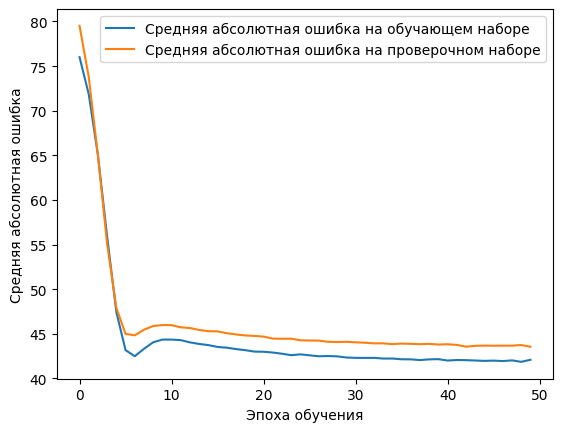

In [ ]:
# Обучение модели на простых данных

model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=x_train_01.shape[1]))
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model_simple.fit(x_train_01,
                    y_train,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

In [ ]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model_simple.predict(x_train_01)

# Расчет среднего значения ошибки
print((abs(pred - y_train)).mean())         # Расчет вручную
print(mean_absolute_error(pred, y_train))   # Расчет с помощью готовой функции

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
42.194007682559615
42.194007682559615


In [ ]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):

    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Средняя абсолютная ошибка: 42.194007682559615 

Реальное значение:  40.00  Предсказанное значение:  60.72  Разница:  20.72
Реальное значение:  40.00  Предсказанное значение:  93.66  Разница:  53.66
Реальное значение: 300.00  Предсказанное значение:  95.67  Разница: 204.33
Реальное значение: 180.00  Предсказанное значение: 103.74  Разница:  76.26
Реальное значение:  40.00  Предсказанное значение:  29.92  Разница:  10.08
Реальное значение: 200.00  Предсказанное значение:  95.67  Разница: 104.33
Реальное значение: 120.00  Предсказанное значение: 111.98  Разница:   8.02
Реальное значение:  50.00  Предсказанное значение:  82.93  Разница:  32.93
Реальное значение:  60.00  Предсказанное значение:  51.84  Разница:   8.16
Реальное значение:  70.00  Предсказанное значение:  77.37  Разница:   7.37


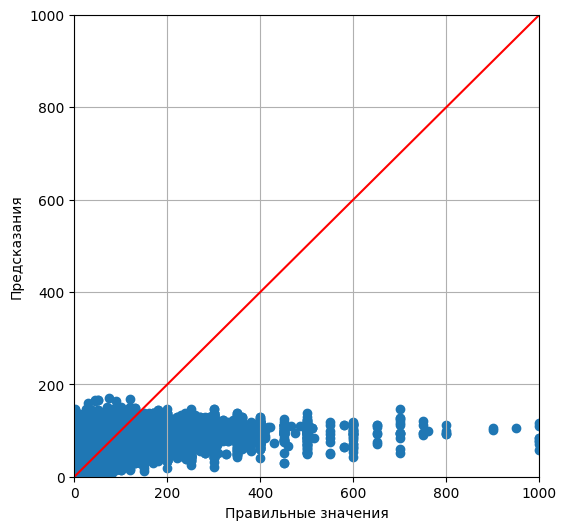

In [ ]:
eval_net(model_simple, x_train_01, y_train)

##Нормализация данных зарплаты

In [ ]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

In [ ]:
# Проверка нормализации
print(y_train_scaled.shape)
print(f'Оригинальное значение зарплаты:  {y_train[1, 0]}')
print(f'Нормированное значение зарплаты: {y_train_scaled[1, 0]}')

# Вывод границ ненормализованных и нормализованных данных
print(y_train.mean(), y_train.std())
print(y_train_scaled.mean(), y_train_scaled.std())

(62967, 1)
Оригинальное значение зарплаты:  40.0
Нормированное значение зарплаты: -0.5247285785360603
77.9847331935776 72.3892975289266
-1.2457941148207006e-16 0.9999999999999998


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.9606 - mae: 0.6239 - val_loss: 0.9874 - val_mae: 0.6360
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.8669 - mae: 0.5937 - val_loss: 0.9537 - val_mae: 0.6069
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.8478 - mae: 0.5871 - val_loss: 0.9445 - val_mae: 0.6042
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8371 - mae: 0.5811 - val_loss: 0.9397 - val_mae: 0.6022
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.8375 - mae: 0.5797 - val_loss: 0.9391 - val_mae: 0.5984
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9098 - mae: 0.5790 - val_loss: 0.9370 - val_mae: 0.5992
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.8980 - mae: 0.5762 - val_loss: 0.9358 - val_mae: 0.5965
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8746 - mae: 0.5769 - val_loss: 0.9334 - val_mae: 0.6031
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/

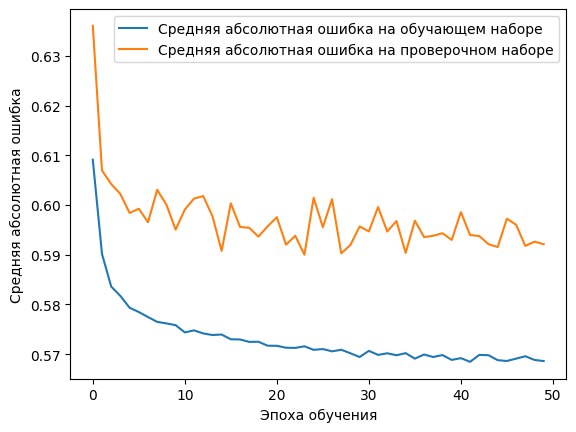

In [ ]:
# Обучение модели на простых данных с нормализованной зарплатой
model_simple = Sequential()
model_simple.add(BatchNormalization(input_dim=x_train_01.shape[1]))
model_simple.add(Dense(128, activation='relu'))
model_simple.add(Dense(1000, activation='tanh'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model_simple.fit(x_train_01,
                    y_train_scaled,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Средняя абсолютная ошибка: 41.25633455461678 

Реальное значение:  40.00  Предсказанное значение:  60.21  Разница:  20.21
Реальное значение:  40.00  Предсказанное значение:  91.54  Разница:  51.54
Реальное значение: 300.00  Предсказанное значение:  94.25  Разница: 205.75
Реальное значение: 180.00  Предсказанное значение:  89.43  Разница:  90.57
Реальное значение:  40.00  Предсказанное значение:  36.73  Разница:   3.27
Реальное значение: 200.00  Предсказанное значение:  94.25  Разница: 105.75
Реальное значение: 120.00  Предсказанное значение: 114.21  Разница:   5.79
Реальное значение:  50.00  Предсказанное значение:  59.91  Разница:   9.91
Реальное значение:  60.00  Предсказанное значение:  45.90  Разница:  14.10
Реальное значение:  70.00  Предсказанное значение:  76.79  Разница:   6.79


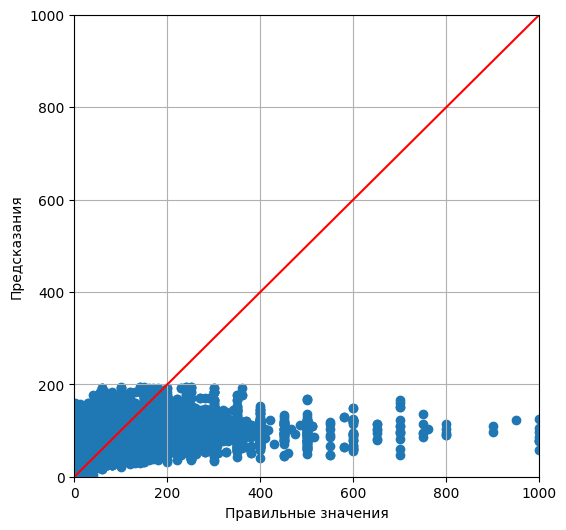

In [ ]:
eval_net(model_simple, x_train_01, y_train, y_scaler)

##Подготовка текстовых данных "Должность"

In [ ]:
# Функция извлечения данных о профессии

def extract_prof_text(row_list):
    result = []

    # Для всех строк таблицы: собрать значения
    # столбцов желаемой и прошлой должности
    # если есть информация о зарплате

    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_POS_SEEK]) + ' ' + str(row[COL_POS_PREV]))

    # Возврат в виде массива
    return result

In [ ]:
# Извлечение текстов о профессии для выборки
prof_text = extract_prof_text(df.values)

# Пример текста о профессии из резюме
print(df.values[120])
print(prof_text[120])

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [ ]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=3000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

tokenizer.fit_on_texts(prof_text)

In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('инженер', 2), ('специалист', 3), ('по', 4), ('менеджер', 5), ('администратор', 6), ('руководитель', 7), ('системный', 8), ('отдела', 9), ('программист', 10), ('ведущий', 11), ('проектов', 12), ('разработчик', 13), ('it', 14), ('поддержки', 15), ('аналитик', 16), ('и', 17), ('технической', 18), ('проекта', 19), ('начальник', 20), ('ит', 21), ('директор', 22), ('интернет', 23), ('с', 24), ('главный', 25), ('старший', 26), ('оператор', 27), ('продажам', 28), ('работе', 29), ('технический', 30), ('монтажник', 31), ('систем', 32), ('developer', 33), ('web', 34), ('связи', 35), ('клиентами', 36), ('информационных', 37), ('консультант', 38), ('группы', 39), ('1с', 40), ('технологий', 41), ('заместитель', 42), ('manager', 43), ('техник', 44), ('дизайнер', 45), ('помощник', 46), ('службы', 47), ('магазина', 48), ('сервисный', 49), ('маркетолог', 50)]
Размер словаря 10025


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
prof_seq = tokenizer.texts_to_sequences(prof_text)

In [ ]:
# Преобразование последовательностей индексов в bag of words
x_train_prof_01 = tokenizer.sequences_to_matrix(prof_seq)

In [ ]:
# Проверка результата
print(x_train_prof_01.shape)

(62967, 3000)


In [ ]:
# Проверка получившихся данных
n = 0
print(prof_text[n])                       # Профессия в тексте
print(prof_seq[n])                        # Профессия в индексах слов
print(x_train_prof_01[n][0:100])          # Профессия в bag of words

Специалист по поддержке чата(support team) домашний агент Генеральный директор
[3, 4, 130, 987, 235, 114, 1, 346, 168, 22]
[0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Освобождение памяти от ненужных более объектов
del prof_text, prof_seq, tokenizer

**Обучение модели на простых текстовых данных**


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.1531 - mae: 0.6474 - val_loss: 1.0645 - val_mae: 0.6613
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9536 - mae: 0.6372 - val_loss: 1.0580 - val_mae: 0.6578
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9179 - mae: 0.6331 - val_loss: 1.0476 - val_mae: 0.6526
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9828 - mae: 0.6344 - val_loss: 1.0326 - val_mae: 0.6451
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9564 - mae: 0.6251 - val_loss: 1.0138 - val_mae: 0.6336
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8879 - mae: 0.6096 - val_loss: 0.9903 - val_mae: 0.6228
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8901 - mae: 0.5940 - val_loss: 0.9644 - val_mae: 0.6100
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8775 - mae: 0.5862 - val_loss: 0.9377 - val_mae: 0.5963
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l

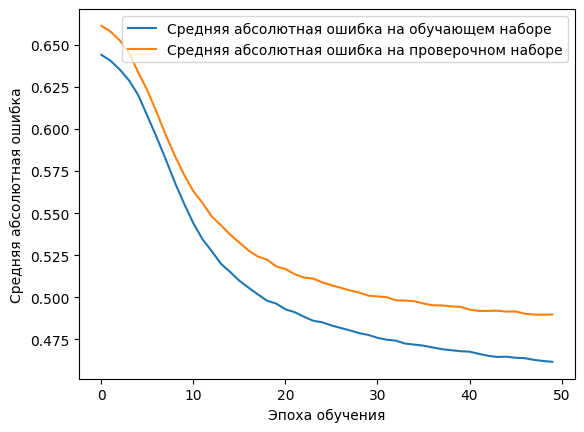

In [ ]:
# Обучение модели на данных о профессии

model_prof = Sequential()
model_prof.add(Dense(20, activation='relu', input_dim=x_train_prof_01.shape[1]))
model_prof.add(Dense(500, activation='relu'))
model_prof.add(Dense(1, activation='linear'))

model_prof.compile(optimizer=Adagrad(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_prof.fit(x_train_prof_01,
                    y_train_scaled,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Средняя абсолютная ошибка: 33.73439701146926 

Реальное значение:  40.00  Предсказанное значение: 119.56  Разница:  79.56
Реальное значение:  40.00  Предсказанное значение:  53.46  Разница:  13.46
Реальное значение: 300.00  Предсказанное значение: 216.15  Разница:  83.85
Реальное значение: 180.00  Предсказанное значение: 107.52  Разница:  72.48
Реальное значение:  40.00  Предсказанное значение:  60.49  Разница:  20.49
Реальное значение: 200.00  Предсказанное значение: 241.57  Разница:  41.57
Реальное значение: 120.00  Предсказанное значение:  70.51  Разница:  49.49
Реальное значение:  50.00  Предсказанное значение:  26.97  Разница:  23.03
Реальное значение:  60.00  Предсказанное значение:  64.06  Разница:   4.06
Реальное значение:  70.00  Предсказанное значение:  44.49  Разница:  25.51


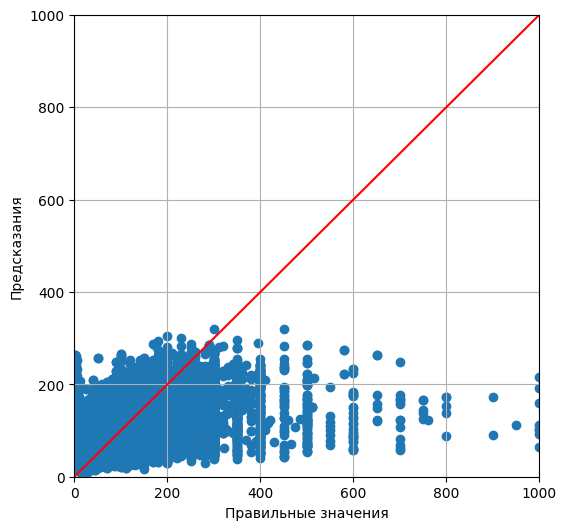

In [ ]:
eval_net(model_prof, x_train_prof_01, y_train, y_scaler)

##Подготовка текстовых данных "Опыт работы"


In [ ]:
# Функция извлечения данных описания опыта работы

def extract_exp_text(row_list):
    result = []

    # Для всех строк таблицы: собрать значения опыта работы,
    # если есть информация о зарплате
    for row in row_list:
        if extract_salary(row[COL_SALARY]) > 0:
            result.append(str(row[COL_EXP]))

    # Возврат в виде массива
    return result

In [ ]:
# Извлечение текстов об опыте работы для выборки
exp_text = extract_exp_text(df.values)

# Пример текста об опыте работы из резюме
print(df.values[120])
print(exp_text[120])

['Мужчина ,  33 года , родился 8 октября 1985' '250000 руб.'
 'Руководитель BI' 'Москва , не готов к переезду , готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 11 лет 6 месяцев  Руководитель BI 250 000 руб. Информационные технологии, интернет, телеком Инженер Аналитик Занятость: полная занятость График работы: полный день Опыт работы 11 лет 6 месяцев Декабрь 2017 — по настоящее время 1 год 5 месяцев ЭркаФарм Россия , erkapharm.com Медицина, фармацевтика, аптеки ... Аптека, оптика Руководитель отдела аналитики Стратегическая цель: создание единой корпоративной автоматизированной информационно-аналитической системы бизнес анализа; MDM: ведение и поддержка в актуальном состоянии мастер-справочников компании; разработка новых справочников\\атрибутов для обеспечения деятельности подразделений компании; контроль бизнес-процессов в части, касающейся мастер-данных; написание документов, закрепляющих регламентные нормы по ведению мастер-справочников; ETL: загрузка данных 

In [ ]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=3000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Построение частотного словаря по текстам профессий
tokenizer.fit_on_texts(exp_text)

In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 124327), ('и', 2), ('в', 3), ('по', 4), ('с', 5), ('на', 6), ('работы', 7), ('месяцев', 8), ('•', 9), ('для', 10), ('1', 11), ('разработка', 12), ('ru', 13), ('интернет', 14), ('2', 15), ('работа', 16), ('опыт', 17), ('года', 18), ('интеграция', 19), ('месяца', 20), ('3', 21), ('москва', 22), ('системная', 23), ('технологии', 24), ('www', 25), ('время', 26), ('системы', 27), ('год', 28), ('лет', 29), ('контроль', 30), ('настройка', 31), ('ооо', 32), ('информационные', 33), ('оборудования', 34), ('компании', 35), ('4', 36), ('5', 37), ('бизнес', 38), ('7', 39), ('поддержка', 40), ('организация', 41), ('2018', 42), ('сети', 43), ('ит', 44), ('8', 45), ('администрирование', 46), ('2017', 47), ('данных', 48), ('систем', 49), ('инженер', 50)]
Размер словаря 325174


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
exp_seq = tokenizer.texts_to_sequences(exp_text)

In [ ]:
# Преобразование последовательностей индексов в bag of words
x_train_exp_01 = tokenizer.sequences_to_matrix(exp_seq)

In [ ]:
# Проверка результата
print(x_train_exp_01.shape)
print(x_train_exp_01[0][0:100])

(62967, 3000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [ ]:
# Проверка получившихся данных
n = 0
print(exp_text[n])                       # Опыт работы в тексте
print(exp_seq[n])                        # Опыт работы в индексах слов
print(x_train_exp_01[n][0:100])          # Опыт работы в bag of words

Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая коммуникация Пользователь ПК Ведение переговоров Управление персоналом Деловая переписка Составление договоров Телефонные переговоры Грамотная речь MS Outlook Водительское удостоверение категории B Работа в команде Возникли неполадки. Попробуйте еще 

In [ ]:
# Освобождение памяти от ненужных более объектов
del exp_text, exp_seq, tokenizer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6900 - mae: 0.4705 - val_loss: 0.5816 - val_mae: 0.4654
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4173 - mae: 0.3764 - val_loss: 0.5014 - val_mae: 0.4045
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2953 - mae: 0.3243 - val_loss: 0.4823 - val_mae: 0.3825
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2164 - mae: 0.2935 - val_loss: 0.4636 - val_mae: 0.3686
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1716 - mae: 0.2633 - val_loss: 0.4643 - val_mae: 0.3576
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1459 - mae: 0.2454 - val_loss: 0.4557 - val_mae: 0.3555
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1306 - mae: 0.2334 - val_loss: 0.4680 - val_mae: 0.3648
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1357 - mae: 0.2277 - val_loss: 0.4549 - val_mae: 0.3461
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/

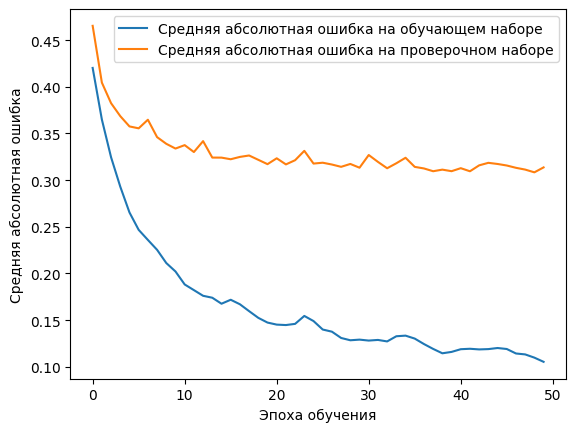

In [ ]:
# Обучение модели на данных об опыте работы (должности)

model_exp = Sequential()
model_exp.add(Dense(30, activation='relu', input_dim=x_train_exp_01.shape[1]))
model_exp.add(Dense(800, activation='relu'))
model_exp.add(Dropout(0.3))
model_exp.add(Dense(1, activation='linear'))

model_exp.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])

history = model_exp.fit(x_train_exp_01,
                    y_train_scaled,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.15,
                    verbose=1)

plot_history(history)

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Средняя абсолютная ошибка: 10.119946376792495 

Реальное значение:  40.00  Предсказанное значение:  40.29  Разница:   0.29
Реальное значение:  40.00  Предсказанное значение:  28.35  Разница:  11.65
Реальное значение: 300.00  Предсказанное значение: 313.69  Разница:  13.69
Реальное значение: 180.00  Предсказанное значение: 178.69  Разница:   1.31
Реальное значение:  40.00  Предсказанное значение:  32.69  Разница:   7.31
Реальное значение: 200.00  Предсказанное значение: 207.60  Разница:   7.60
Реальное значение: 120.00  Предсказанное значение: 115.21  Разница:   4.79
Реальное значение:  50.00  Предсказанное значение:  44.69  Разница:   5.31
Реальное значение:  60.00  Предсказанное значение:  49.71  Разница:  10.29
Реальное значение:  70.00  Предсказанное значение:  61.64  Разница:   8.36


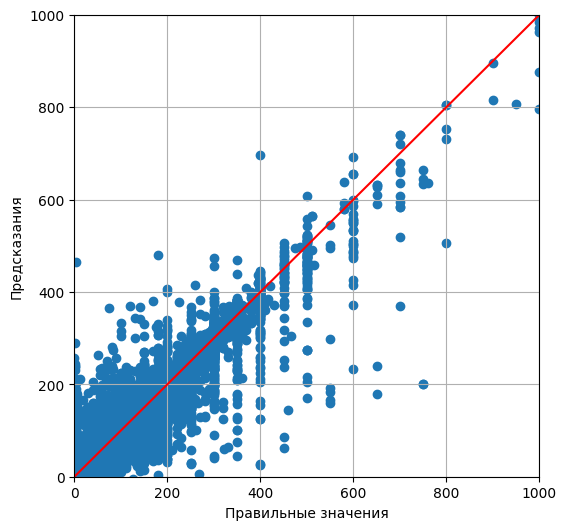

In [ ]:
eval_net(model_exp, x_train_exp_01, y_train, y_scaler)

##Обучение нейронной сети класса Model

In [ ]:
# Освобождение памяти
del model_simple, model_prof, model_exp

In [ ]:
input1 = Input((x_train_01.shape[1],))
input2 = Input((x_train_prof_01.shape[1],))
input3 = Input((x_train_exp_01.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x3 = input3                               # Ветка 3
x3 = Dense(30, activation="relu")(x3)
x3 = Dense(800, activation="relu")(x3)
x3 = Dropout(0.3)(x3)

x = concatenate([x1, x2, x3])             # Объединение трех веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2, input3), x)

In [ ]:
x1 = input1
x1 = Dense(128, activation="relu")(x1) #(x1) - то, откуда придут данные на полносвязный слой

In [ ]:
model_final = Model((input1, input2, input3), x)

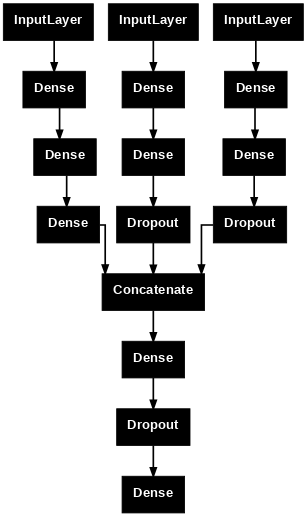

In [ ]:
utils.plot_model(model_final, dpi=60)

In [ ]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final.fit([x_train_01, x_train_prof_01, x_train_exp_01],
                           y_train_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1)

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.8126 - mae: 0.5295 - val_loss: 0.5275 - val_mae: 0.4107
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.4786 - mae: 0.4087 - val_loss: 0.4779 - val_mae: 0.3959
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.3591 - mae: 0.3700 - val_loss: 0.4623 - val_mae: 0.3795
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.3622 - mae: 0.3556 - val_loss: 0.4508 - val_mae: 0.3746
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.3299 - mae: 0.3458 - val_loss: 0.4546 - val_mae: 0.3668
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.2822 - mae: 0.3282 - val_loss: 0.4599 - val_mae: 0.3547
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.2399 - mae: 0.3185 - val_loss: 0.4443 - val_mae: 0.3546
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.2457 - mae: 0.3186 - val_loss: 0.4507 - val_mae: 0.3512
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 31

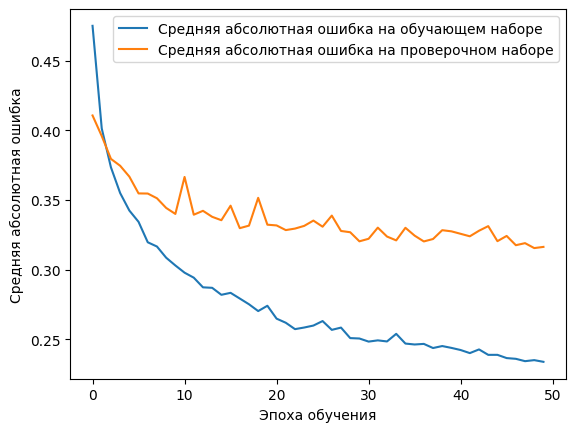

In [ ]:
plot_history(history)

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Средняя абсолютная ошибка: 13.29030682894829 

Реальное значение:  40.00  Предсказанное значение:  46.03  Разница:   6.03
Реальное значение:  40.00  Предсказанное значение:  61.04  Разница:  21.04
Реальное значение: 300.00  Предсказанное значение: 287.78  Разница:  12.22
Реальное значение: 180.00  Предсказанное значение: 175.83  Разница:   4.17
Реальное значение:  40.00  Предсказанное значение:  36.10  Разница:   3.90
Реальное значение: 200.00  Предсказанное значение: 173.32  Разница:  26.68
Реальное значение: 120.00  Предсказанное значение: 114.45  Разница:   5.55
Реальное значение:  50.00  Предсказанное значение:  34.29  Разница:  15.71
Реальное значение:  60.00  Предсказанное значение:  61.69  Разница:   1.69
Реальное значение:  70.00  Предсказанное значение:  61.97  Разница:   8.03


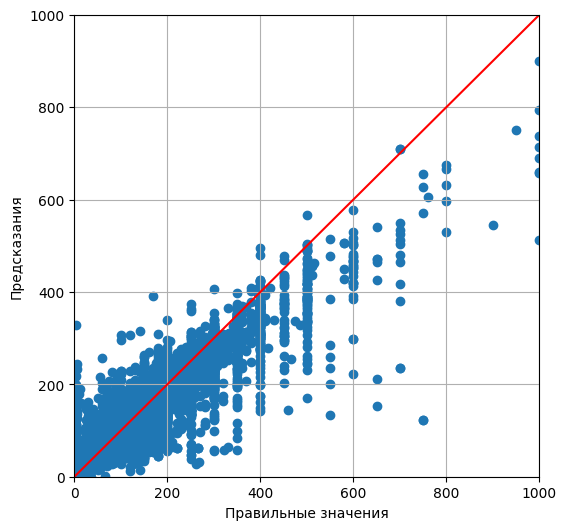

In [ ]:
eval_net(model_final, [x_train_01, x_train_prof_01, x_train_exp_01], y_train, y_scaler)